## 2023 Open Science Data Challenge - Sentinel-1 Phenology

This notebook calculates vegetation phenology changes using radiometrically terrain corrected Sentinel-1 radar data. To detect vegetation changes, the algorithm uses variations in the Radar Vegetation Index (RVI) which is a common proxy for vegetation growth and health. The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting. The baseline data is [Sentinel-1 RTC](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) data from the MS Planetary Computer catalog. For more information about how to interpret radar data, see the following document: "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.


In [12]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer as pc
import xrspatial.multispectral as ms
import odc
from odc.stac import stac_load

# Pass your API key here
pc.settings.set_subscription_key('85c168c81886441d89c30d0bd8613cc0')

### Discover and load the data for analysis

Our test region is a rice crop field in Vietnam. First, we define our area of interest using latitude and longitude coordinates of the centroid. Then we define the size of the surrounding bounding box (in degrees). GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates.

In [13]:
# Rice Crop Field in An Giang, Vietnam

lat_long = (10.4391, 105.3338) # Lat-Lon centroid location
box_size_deg = 0.1 # Surrounding box in degrees
min_lon = lat_long[1]-box_size_deg/2
min_lat = lat_long[0]-box_size_deg/2
max_lon = lat_long[1]+box_size_deg/2
max_lat = lat_long[0]+box_size_deg/2

bbox = (min_lon, min_lat, max_lon, max_lat)

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will use a time window in late-2021 to early-2022 when we know there is a rice crop growing cycle. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes. 

In [14]:
time_of_interest = "2021-12-01/2022-04-30"

In [15]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest)
items = list(search.get_all_items()) # This produces a list of scene IDs

Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) using [stackstac](https://stackstac.readthedocs.io/) and then "clip" the data to only the pixels within our region (bounding box). We will only keep the desired bands (VV, VH) since they are needed to create the Radar Vegetation Index (RVI). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees and we have specified the spatial resolution of each pixel to be 10-meters, which is the baseline accuracy for this data. 

In [16]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees

resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [17]:
# Load the data using Open Data Cube
data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox, crs="EPSG:4326", resolution=scale)

In [18]:
# View the details of our xarray dataset
# The X and Y dimensions tell us the pixel dimensions of our bounding box
# The "time" variable is the number of scenes that touch our region
data

<xarray.Dataset>
Dimensions:      (latitude: 1114, longitude: 1114, time: 27)
Coordinates:
  * latitude     (latitude) float64 10.49 10.49 10.49 ... 10.39 10.39 10.39
  * longitude    (longitude) float64 105.3 105.3 105.3 ... 105.4 105.4 105.4
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2021-12-04T22:46:07.919581 ... 2022-04...
Data variables:
    vv           (time, latitude, longitude) float32 0.02417 0.01493 ... 0.272
    vh           (time, latitude, longitude) float32 0.004146 ... 0.01252

### Radar Vegetation Index (RVI)

The <b>Radar Vegetation Index (RVI)</b> is one example of an index used to measure vegetation growth with radar data. Since radar data can penetrate clouds, such indices are valuable to monitor crop phenology (growth). For more information on the RVI formula, see the following Sentinel Hub link: <a href="https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/radar_vegetation_index/" target="_blank"><b>HERE</b></a>.


In [19]:
# Calculate the mean of the data across the sample region
mean = data.mean(dim=['latitude','longitude']).compute()

In [20]:
# Calculate RVI
dop = (mean.vv / (mean.vv + mean.vh))
m = 1 - dop
rvi = (np.sqrt(dop))*((4*mean.vh)/(mean.vv + mean.vh))

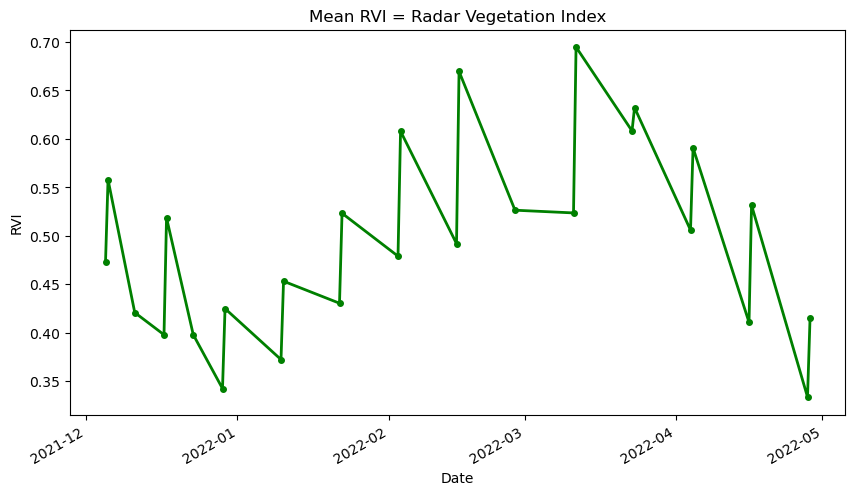

In [21]:
fig = plt.figure(figsize=(10, 5))
rvi.plot(color='green',marker='o',markersize=4,linewidth=2)
plt.title("Mean RVI = Radar Vegetation Index")
plt.xlabel("Date")
plt.ylabel("RVI")
plt.show()